In [1]:
####
#### If you are not using GPUs, just remove .to(device=cuda) everywhere
####

import torch
import torch.nn as nn
from torch.utils import data
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav

from os import listdir
from pysndfx import AudioEffectsChain
from tqdm import tqdm
from IPython.display import Audio
from types import SimpleNamespace

from datasets import *
from networks import *

In [2]:
### Params structures

optim = {'batch_size' :  256, 'rate_constant' : 1}
effect = {'name': 'pysndfx_overdrive', 'od_gain' : 20, 'od_colour' : 100,'FS' : 44100}
network = {
    'n_kernel' : 20,
    'n_layers' : 20,
    'n_stacks' : 1,
    'n_input' : 0,
    'skip_type' : 'skip-layer',
    'readout' : 'read-all',
    'module_type' : 'causal', 
    'activation': 'elu',
    'act_p1': 1,
    'act_p2': 0,
    'activation_output' : 'identity',
    'act_out_p1': 1,
}

params = SimpleNamespace(
    optim = optim,
    net = network,
    effect = effect,
)


dil = [ 2**k  if params.net['module_type'] == 'dilated'
       else 1 for k in range(params.net['n_layers'])] * params.net['n_stacks']
params.net['n_input'] = sum([d * (params.net['n_kernel'] - 1) for d in dil]) + 1

In [3]:
#### Create sound efffect
overdrive = (
    AudioEffectsChain()
    .overdrive(gain=params.effect['od_gain'],colour=params.effect['od_colour'])
)

#### Generate dataset
folder = 'datasets/'
fileslist = []
fileslist += [folder+item for item in listdir(folder) if not item.startswith('.')]

train_dry = wav.read(fileslist[0])[1]  ## Pick song to train network
train_dry = train_dry/train_dry.max() ## Normalise
train_wet = overdrive(train_dry)

test_dry = wav.read(fileslist[1])[1]  ## Pick song to test network
test_dry = test_dry/test_dry.max()
test_dry = test_dry[:1000000] ## 
test_wet = overdrive(test_dry)

audio_samples_train = asc_dynamic(train_dry,train_wet,width=params.net['n_input'])
dataloader_train = data.DataLoader(audio_samples_train, batch_size=params.optim['batch_size'], shuffle=True)
audio_samples_test = asc_dynamic(test_dry,test_wet,width=params.net['n_input'])
dataloader_test = data.DataLoader(audio_samples_test, batch_size=params.optim['batch_size'], shuffle=False)


Loss: 0.00318:   8%|▊         | 4002/49725 [03:30<37:24, 20.37it/s]

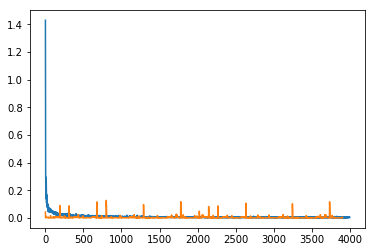

In [4]:
### Create network
cuda = torch.device('cuda')
model = AudioNet(**params.net).to(device=cuda)

## Train network
criterion = nn.MSELoss()
learning_rate = params.optim['rate_constant']/params.optim['batch_size']
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

loss_train = []
loss_test = []

#### Training
model.train()
pbar = tqdm(dataloader_train)
for i, (dry,wet) in enumerate(pbar): 
    dry = dry.view(-1,1,params.net['n_input'])
    dry = dry.to(device=cuda)
    wet = wet.to(device=cuda)
    wet_out = model(dry)
    loss = criterion(wet_out.squeeze(),wet.squeeze())

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())   

    pbar.set_description('Loss: {}'.format(round(loss.item(),5)))
    pbar.update(1)
    if i > 4000:
        break

### Testing
model.eval()
with torch.set_grad_enabled(False):
    for dry,wet in dataloader_test:
        dry = dry.view(-1,1,params.net['n_input'])
        dry = dry.to(device=cuda)
        wet = wet.to(device=cuda)
        wet_out = model(dry)
        loss = criterion(wet_out.squeeze(),wet.squeeze())
        loss_test.append(loss.item())

plt.plot(loss_train)
plt.plot(loss_test)

In [9]:
FS = params.effect['FS']
Audio(test_dry, rate=FS)

In [10]:
Audio(test_wet, rate=FS)

In [11]:
audio_samples_test = asc_dynamic(test_dry,test_wet,width=params.net['n_input'])
dataloader_test_end = data.DataLoader(audio_samples_test, batch_size=params.optim['batch_size'], shuffle=False)
cuda = torch.device('cuda')
## Reconstructing test output
model_wet = []
model.eval()
with torch.set_grad_enabled(False):
    for dry, _ in dataloader_test_end:
        dry = dry.view(-1,1,params.net['n_input'])
        dry = dry.to(device=cuda)
        model_wet.extend(model(dry).squeeze().tolist())
        
Audio(model_wet, rate=FS)

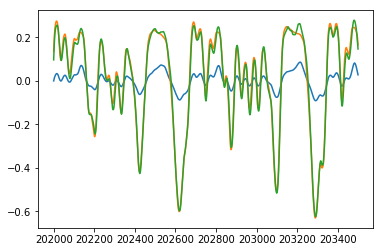

In [12]:
# Test plot
res = test_wet - model_wet
st = 202000
nd = 203500
plt.plot(np.arange(st,nd),test_dry[st:nd])
plt.plot(np.arange(st,nd),test_wet[st:nd])
plt.plot(np.arange(st,nd),model_wet[st:nd])